In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from termcolor import colored as cl 
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('House_Data.csv')
df.set_index('Id', inplace = True)

df.head(5)

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
Id,,,,,,,,,,,
1,8450,196.0,150,856,856,854,1710,548,0,61,208500
2,9600,0.0,284,1262,1262,0,1262,460,298,0,181500
3,11250,162.0,434,920,920,866,1786,608,0,42,223500
4,9550,0.0,540,756,961,756,1717,642,0,35,140000
5,14260,350.0,490,1145,1145,1053,2198,836,192,84,250000


In [3]:
df.isna().sum()

LotArea        0
MasVnrArea     8
BsmtUnfSF      0
TotalBsmtSF    0
1stFlrSF       0
2ndFlrSF       0
GrLivArea      0
GarageArea     0
WoodDeckSF     0
OpenPorchSF    0
SalePrice      0
dtype: int64

In [4]:

df = df.fillna(df.mean())


In [5]:
df.dropna(inplace = True)

print(cl(df.isnull().sum(), attrs = ['bold']))

df.describe()

print(cl(df.dtypes, attrs = ['bold']))

LotArea        0
MasVnrArea     0
BsmtUnfSF      0
TotalBsmtSF    0
1stFlrSF       0
2ndFlrSF       0
GrLivArea      0
GarageArea     0
WoodDeckSF     0
OpenPorchSF    0
SalePrice      0
dtype: int64
LotArea          int64
MasVnrArea     float64
BsmtUnfSF        int64
TotalBsmtSF      int64
1stFlrSF         int64
2ndFlrSF         int64
GrLivArea        int64
GarageArea       int64
WoodDeckSF       int64
OpenPorchSF      int64
SalePrice        int64
dtype: object


In [6]:
df.dropna(subset=['MasVnrArea'], inplace=True)  
df['MasVnrArea'] = df['MasVnrArea'].astype('int64')
df['MasVnrArea'] = pd.to_numeric(df['MasVnrArea'], errors='coerce').astype('Int64')

print(cl(df.dtypes, attrs = ['bold']))


LotArea        int64
MasVnrArea     Int64
BsmtUnfSF      int64
TotalBsmtSF    int64
1stFlrSF       int64
2ndFlrSF       int64
GrLivArea      int64
GarageArea     int64
WoodDeckSF     int64
OpenPorchSF    int64
SalePrice      int64
dtype: object


In [7]:
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(36, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.16))
    model.add(LSTM(18, activation='relu', return_sequences=True))
    model.add(Dropout(0.16))
    model.add(LSTM(9, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [8]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    history = model.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_val, y_val))
    return history


In [9]:
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
features = ['LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
target = 'SalePrice'

X = df[features].values
y = df[target].values

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))


In [12]:


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

mse_scores = []
train_loss = []
val_loss = []


In [14]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]


    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))


    model = create_model((X_train.shape[1], X_train.shape[2]))


    history = train_and_evaluate_model(model, X_train, y_train, X_val, y_val)


    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])


    y_pred = model.predict(X_val)

    
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

10/10 [==============================] - 0s 1ms/step


In [15]:
print(f'Validation MSE: {np.mean(mse_scores)}')


Validation MSE: 0.003609829648081713


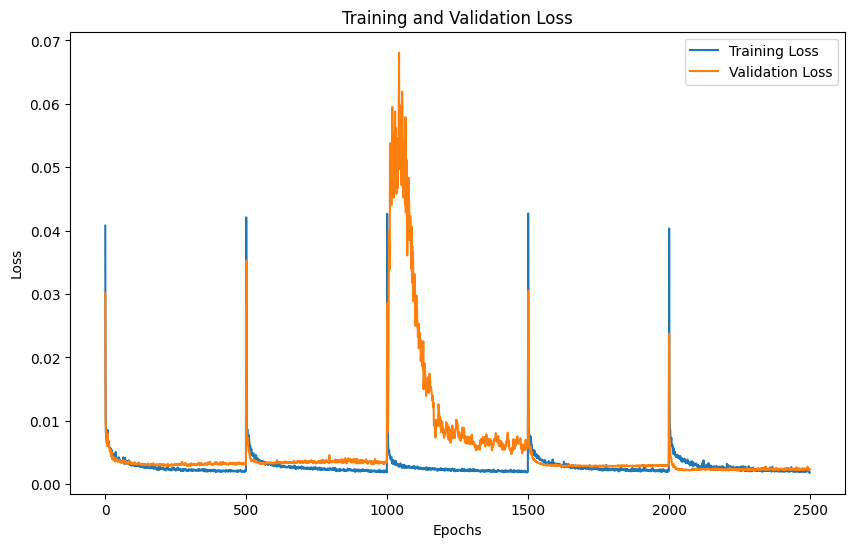

In [16]:
plot_loss(train_loss, val_loss)

In [17]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_pred_test = model.predict(X_test)
y_pred_test_orig = scaler.inverse_transform(y_pred_test)
y_test_orig = scaler.inverse_transform(y_test)

for pred, orig in zip(y_pred_test_orig, y_test_orig):
    print(f'Predicted: {pred[0]}, Original: {orig[0]}')


14/14 [==============================] - 0s 1ms/step


plot for tesgt set between orginal and predection

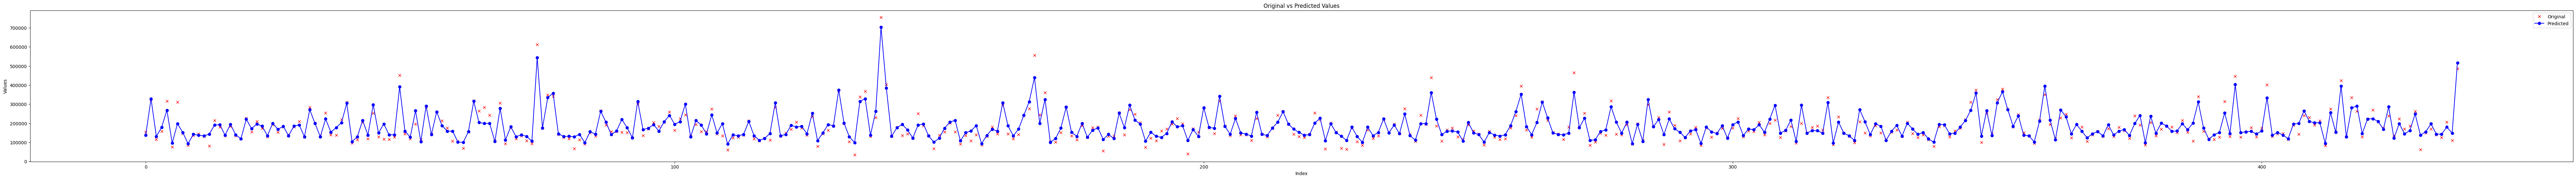

In [18]:
plt.figure(figsize=(100, 6))
plt.plot(y_test_orig, 'rx', label='Original')
plt.plot(y_pred_test_orig, 'bo-', label='Predicted')
plt.title('Original vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

For the test set

In [19]:
 


mae = mean_absolute_error(y_test_orig, y_pred_test_orig)
mse = mean_squared_error(y_test_orig, y_pred_test_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred_test_orig)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared (R²): {r2}")

Mean Absolute Error (MAE): 19990.260612871003
Mean Squared Error (MSE): 780761273.7717514
Root Mean Squared Error (RMSE): 27942.105750493312
R-Squared (R²): 0.888112527501113
